In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
# import pytorch_wavelets as pw
from torch.nn.modules.utils import _pair, _quadruple
import pywt

In [2]:
'''
define image transforms, link two transforms together, 
1.) changes the image(color) to a tensor
2.) normalize image from range [0,1] to range [-1,1]
'''
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root=r'C:\Users\Alec\Documents\Data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=r'C:\Users\Alec\Documents\Data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def imgshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    

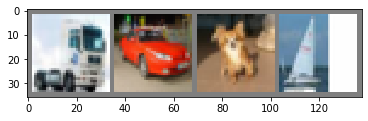

truck   car   dog  ship


In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imgshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
#batchsize is 4, which is we can show images in groups of 4

In [49]:
def get_wav(in_channels,  pool=True):
    """wavelet decomposition using conv2d"""
    
    w = pywt.Wavelet('coif1')
    
    dec_hi = torch.Tensor(w.dec_hi[::-1]) 
    dec_lo = torch.Tensor(w.dec_lo[::-1])
    rec_hi = torch.Tensor(w.rec_hi)
    rec_lo = torch.Tensor(w.rec_lo)
    
    filter_LL = dec_lo.unsqueeze(0)*dec_lo.unsqueeze(1)
    filter_LH = dec_lo.unsqueeze(0)*dec_hi.unsqueeze(1)
    filter_HL = dec_hi.unsqueeze(0)*dec_lo.unsqueeze(1)
    filter_HH = dec_hi.unsqueeze(0)*dec_hi.unsqueeze(1)
 
    if pool:
        model = nn.Conv2d
    else:
        model = nn.ConvTranspose2d

    LL = model(in_channels, in_channels,
             kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    LH = model(in_channels, in_channels,
             kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    HL = model(in_channels, in_channels,kernel_size=1, stride=2, padding=0, bias=False,
             groups=in_channels)
    HH = model(in_channels, in_channels,kernel_size=1, stride=2, padding=0, bias=False,
             groups=in_channels)

    LL.weight.requires_grad = False
    LH.weight.requires_grad = False
    HL.weight.requires_grad = False
    HH.weight.requires_grad = False

    LL.weight.data = filter_LL.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    LH.weight.data = filter_LH.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    HL.weight.data = filter_HL.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    HH.weight.data = filter_HH.float().unsqueeze(0).expand(in_channels, -1, -1, -1)

    return LL, LH, HL, HH

class WavePool(nn.Module):
    def __init__(self,in_channels):
        super(WavePool,self).__init__()
        self.LL,self.LH,self.HL,self.HH = get_wav(in_channels)

    def forward(self,x):
        return self.LL(x)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2,2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [7]:
maxnet = Net()
train_loss = []
run_loss = []
test_loss = []
test_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(maxnet.parameters(), lr=0.001, momentum=0.9)


for epoch in range(10):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = maxnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = maxnet(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 12000 test images: %d %%' % (
            100 * correct / total))
    
    

    test_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.722
[1,  2000] running loss: 0.325
[1,  3000] running loss: 0.200
[1,  4000] running loss: 0.140
[1,  5000] running loss: 0.110
[1,  6000] running loss: 0.088
[1,  7000] running loss: 0.074
[1,  8000] running loss: 0.064
[1,  9000] running loss: 0.055
[1, 10000] running loss: 0.049
[1, 11000] running loss: 0.044
[1, 12000] running loss: 0.040
Accuracy of the network on the 12000 test images: 50 %
Epoch 1, Training Loss:  0.547, Testing Accuracy: 0.507
[2,  1000] running loss: 0.449
[2,  2000] running loss: 0.220
[2,  3000] running loss: 0.146
[2,  4000] running loss: 0.109
[2,  5000] running loss: 0.087
[2,  6000] running loss: 0.071
[2,  7000] running loss: 0.060
[2,  8000] running loss: 0.053
[2,  9000] running loss: 0.047
[2, 10000] running loss: 0.041
[2, 11000] running loss: 0.038
[2, 12000] running loss: 0.035
Accuracy of the network on the 12000 test images: 55 %
Epoch 2, Training Loss:  0.426, Testing Accuracy: 0.559
[3,  1000] running loss: 0.379
[3,

In [13]:
max_pool_acc = [0.5133,
 0.5638,
 0.5814,
 0.6053,
 0.6027,
 0.6108,
 0.6119,
 0.6103,
 0.6062,
 0.6035]


Text(0, 0.5, 'Error')

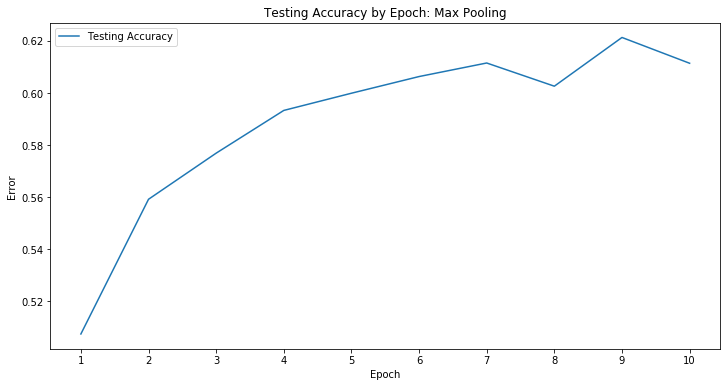

In [8]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,11, step=1), test_accuracy, label = 'Testing Accuracy')
plt.title('Testing Accuracy by Epoch: Max Pooling')
plt.xticks(np.arange(1,11, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')

In [9]:
class MeanNet(nn.Module):
    def __init__(self):
        super(MeanNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.AvgPool2d(2,2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [10]:
meannet = MeanNet()
train_loss = []
run_loss = []
test_loss = []
test_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(meannet.parameters(), lr=0.001, momentum=0.9)


for epoch in range(10):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = meannet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = meannet(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 12000 test images: %d %%' % (
            100 * correct / total))
    
    

    test_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.714
[1,  2000] running loss: 0.327
[1,  3000] running loss: 0.202
[1,  4000] running loss: 0.146
[1,  5000] running loss: 0.113
[1,  6000] running loss: 0.092
[1,  7000] running loss: 0.076
[1,  8000] running loss: 0.066
[1,  9000] running loss: 0.058
[1, 10000] running loss: 0.052
[1, 11000] running loss: 0.047
[1, 12000] running loss: 0.042
Accuracy of the network on the 12000 test images: 47 %
Epoch 1, Training Loss:  0.563, Testing Accuracy: 0.471
[2,  1000] running loss: 0.494
[2,  2000] running loss: 0.237
[2,  3000] running loss: 0.159
[2,  4000] running loss: 0.119
[2,  5000] running loss: 0.094
[2,  6000] running loss: 0.080
[2,  7000] running loss: 0.065
[2,  8000] running loss: 0.057
[2,  9000] running loss: 0.051
[2, 10000] running loss: 0.045
[2, 11000] running loss: 0.040
[2, 12000] running loss: 0.037
Accuracy of the network on the 12000 test images: 51 %
Epoch 2, Training Loss:  0.463, Testing Accuracy: 0.520
[3,  1000] running loss: 0.424
[3,

In [11]:
mean_pool_acc = test_accuracy

Text(0, 0.5, 'Error')

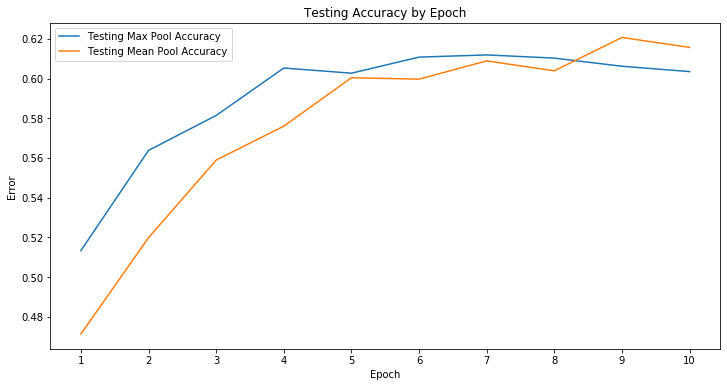

In [14]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,11, step=1), max_pool_acc, label = 'Testing Max Pool Accuracy')
plt.plot(np.arange(1,11, step=1), mean_pool_acc, label = 'Testing Mean Pool Accuracy')
plt.title('Testing Accuracy by Epoch')
plt.xticks(np.arange(1,11, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')

## Wavelet Pooling

In [15]:
class HaarNet(nn.Module):
    def __init__(self):
        super(HaarNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = WavePool(64)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [16]:
Haarnet = HaarNet()
train_loss = []
run_loss = []
test_loss = []
haar_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(Haarnet.parameters(), lr=0.001, momentum=0.9)


for epoch in range(10):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = Haarnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = Haarnet(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 12000 test images: %d %%' % (
            100 * correct / total))
    
    

    haar_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.694
[1,  2000] running loss: 0.310
[1,  3000] running loss: 0.196
[1,  4000] running loss: 0.140
[1,  5000] running loss: 0.108
[1,  6000] running loss: 0.089
[1,  7000] running loss: 0.075
[1,  8000] running loss: 0.064
[1,  9000] running loss: 0.056
[1, 10000] running loss: 0.050
[1, 11000] running loss: 0.045
[1, 12000] running loss: 0.041
Accuracy of the network on the 12000 test images: 48 %
Epoch 1, Training Loss:  0.544, Testing Accuracy: 0.488
[2,  1000] running loss: 0.462
[2,  2000] running loss: 0.233
[2,  3000] running loss: 0.152
[2,  4000] running loss: 0.113
[2,  5000] running loss: 0.089
[2,  6000] running loss: 0.074
[2,  7000] running loss: 0.063
[2,  8000] running loss: 0.055
[2,  9000] running loss: 0.049
[2, 10000] running loss: 0.043
[2, 11000] running loss: 0.039
[2, 12000] running loss: 0.036
Accuracy of the network on the 12000 test images: 55 %
Epoch 2, Training Loss:  0.445, Testing Accuracy: 0.551
[3,  1000] running loss: 0.399
[3,

Text(0, 0.5, 'Error')

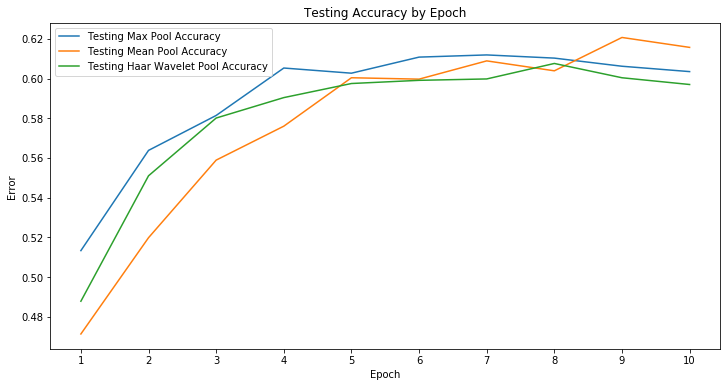

In [17]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,11, step=1), max_pool_acc, label = 'Testing Max Pool Accuracy')
plt.plot(np.arange(1,11, step=1), mean_pool_acc, label = 'Testing Mean Pool Accuracy')
plt.plot(np.arange(1,11, step=1), haar_accuracy, label = 'Testing Haar Wavelet Pool Accuracy')
plt.title('Testing Accuracy by Epoch')
plt.xticks(np.arange(1,11, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')

In [26]:
class db1Net(nn.Module):
    def __init__(self):
        super(db1Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = WavePool(64)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [27]:
db1net = db1Net()
train_loss = []
run_loss = []
test_loss = []
db1_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(db1net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(10):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = db1net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = db1net(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 12000 test images: %d %%' % (
            100 * correct / total))
    
    

    db1_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.699
[1,  2000] running loss: 0.310
[1,  3000] running loss: 0.196
[1,  4000] running loss: 0.140
[1,  5000] running loss: 0.108
[1,  6000] running loss: 0.088
[1,  7000] running loss: 0.076
[1,  8000] running loss: 0.064
[1,  9000] running loss: 0.056
[1, 10000] running loss: 0.050
[1, 11000] running loss: 0.045
[1, 12000] running loss: 0.040
Accuracy of the network on the 12000 test images: 48 %
Epoch 1, Training Loss:  0.544, Testing Accuracy: 0.486
[2,  1000] running loss: 0.484
[2,  2000] running loss: 0.227
[2,  3000] running loss: 0.153
[2,  4000] running loss: 0.113
[2,  5000] running loss: 0.090
[2,  6000] running loss: 0.075
[2,  7000] running loss: 0.063
[2,  8000] running loss: 0.056
[2,  9000] running loss: 0.048
[2, 10000] running loss: 0.043
[2, 11000] running loss: 0.039
[2, 12000] running loss: 0.036
Accuracy of the network on the 12000 test images: 52 %
Epoch 2, Training Loss:  0.447, Testing Accuracy: 0.521
[3,  1000] running loss: 0.391
[3,

Text(0, 0.5, 'Error')

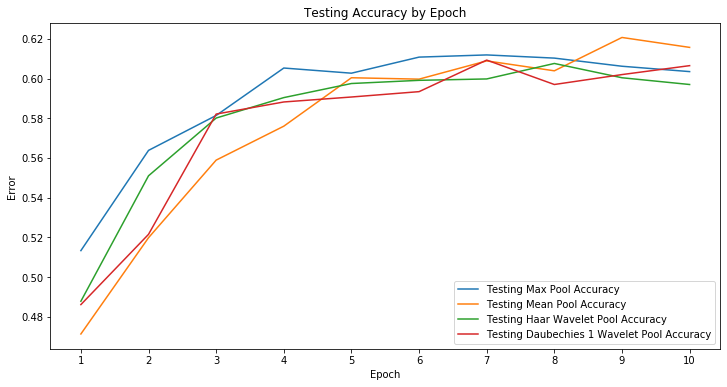

In [28]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,11, step=1), max_pool_acc, label = 'Testing Max Pool Accuracy')
plt.plot(np.arange(1,11, step=1), mean_pool_acc, label = 'Testing Mean Pool Accuracy')
plt.plot(np.arange(1,11, step=1), haar_accuracy, label = 'Testing Haar Wavelet Pool Accuracy')
plt.plot(np.arange(1,11, step=1), db1_accuracy, label = 'Testing Daubechies 1 Wavelet Pool Accuracy')

plt.title('Testing Accuracy by Epoch')
plt.xticks(np.arange(1,11, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')

In [36]:
class db2Net(nn.Module):
    def __init__(self):
        super(db2Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(10816, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = WavePool(64)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [38]:
db2net = db2Net()
train_loss = []
run_loss = []
test_loss = []
db2_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(db2net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(10):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = db2net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = db2net(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 12000 test images: %d %%' % (
            100 * correct / total))
    
    

    db2_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.707
[1,  2000] running loss: 0.319
[1,  3000] running loss: 0.201
[1,  4000] running loss: 0.145
[1,  5000] running loss: 0.111
[1,  6000] running loss: 0.090
[1,  7000] running loss: 0.077
[1,  8000] running loss: 0.066
[1,  9000] running loss: 0.058
[1, 10000] running loss: 0.051
[1, 11000] running loss: 0.045
[1, 12000] running loss: 0.041
Accuracy of the network on the 12000 test images: 45 %
Epoch 1, Training Loss:  0.557, Testing Accuracy: 0.455
[2,  1000] running loss: 0.481
[2,  2000] running loss: 0.237
[2,  3000] running loss: 0.158
[2,  4000] running loss: 0.118
[2,  5000] running loss: 0.094
[2,  6000] running loss: 0.079
[2,  7000] running loss: 0.065
[2,  8000] running loss: 0.056
[2,  9000] running loss: 0.051
[2, 10000] running loss: 0.045
[2, 11000] running loss: 0.040
[2, 12000] running loss: 0.036
Accuracy of the network on the 12000 test images: 53 %
Epoch 2, Training Loss:  0.461, Testing Accuracy: 0.540
[3,  1000] running loss: 0.419
[3,

Text(0, 0.5, 'Accuracy')

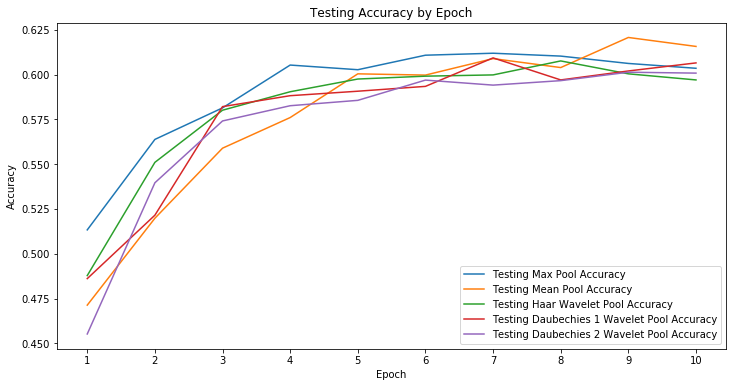

In [42]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,11, step=1), max_pool_acc, label = 'Testing Max Pool Accuracy')
plt.plot(np.arange(1,11, step=1), mean_pool_acc, label = 'Testing Mean Pool Accuracy')
plt.plot(np.arange(1,11, step=1), haar_accuracy, label = 'Testing Haar Wavelet Pool Accuracy')
plt.plot(np.arange(1,11, step=1), db1_accuracy, label = 'Testing Daubechies 1 Wavelet Pool Accuracy')
plt.plot(np.arange(1,11, step=1), db2_accuracy, label = 'Testing Daubechies 2 Wavelet Pool Accuracy')
plt.title('Testing Accuracy by Epoch')
plt.xticks(np.arange(1,11, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [70]:
class coif1Net(nn.Module):
    def __init__(self):
        super(coif1Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = WavePool(64)

        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [71]:
coif1net = coif1Net()
train_loss = []
run_loss = []
test_loss = []
coif1_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(coif1net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(10):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = coif1net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = coif1net(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 12000 test images: %d %%' % (
            100 * correct / total))
    
    

    coif1_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.704
[1,  2000] running loss: 0.316
[1,  3000] running loss: 0.201
[1,  4000] running loss: 0.144
[1,  5000] running loss: 0.111
[1,  6000] running loss: 0.091
[1,  7000] running loss: 0.076
[1,  8000] running loss: 0.066
[1,  9000] running loss: 0.059
[1, 10000] running loss: 0.052
[1, 11000] running loss: 0.046
[1, 12000] running loss: 0.041
Accuracy of the network on the 12000 test images: 48 %
Epoch 1, Training Loss:  0.558, Testing Accuracy: 0.482
[2,  1000] running loss: 0.486
[2,  2000] running loss: 0.241
[2,  3000] running loss: 0.161
[2,  4000] running loss: 0.120
[2,  5000] running loss: 0.095
[2,  6000] running loss: 0.079
[2,  7000] running loss: 0.067
[2,  8000] running loss: 0.059
[2,  9000] running loss: 0.050
[2, 10000] running loss: 0.045
[2, 11000] running loss: 0.040
[2, 12000] running loss: 0.038
Accuracy of the network on the 12000 test images: 52 %
Epoch 2, Training Loss:  0.467, Testing Accuracy: 0.523
[3,  1000] running loss: 0.424
[3,

Text(0, 0.5, 'Accuracy')

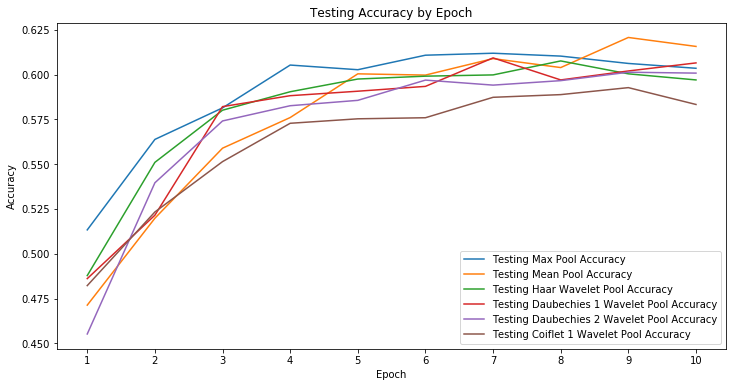

In [72]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,11, step=1), max_pool_acc, label = 'Testing Max Pool Accuracy')
plt.plot(np.arange(1,11, step=1), mean_pool_acc, label = 'Testing Mean Pool Accuracy')
plt.plot(np.arange(1,11, step=1), haar_accuracy, label = 'Testing Haar Wavelet Pool Accuracy')
plt.plot(np.arange(1,11, step=1), db1_accuracy, label = 'Testing Daubechies 1 Wavelet Pool Accuracy')
plt.plot(np.arange(1,11, step=1), db2_accuracy, label = 'Testing Daubechies 2 Wavelet Pool Accuracy')
plt.plot(np.arange(1,11, step=1), coif1_accuracy, label = 'Testing Coiflet 1 Wavelet Pool Accuracy')
plt.title('Testing Accuracy by Epoch')
plt.xticks(np.arange(1,11, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [74]:
coif1_accuracy

[0.4822,
 0.5233,
 0.5514,
 0.5728,
 0.5753,
 0.5759,
 0.5873,
 0.5888,
 0.5927,
 0.5833]

In [20]:
haar_accuracy

[0.4878, 0.551, 0.5801, 0.5904, 0.5975, 0.5991, 0.5998, 0.6076, 0.6004, 0.597]

In [22]:
mean_pool_acc

[0.4713, 0.5198, 0.5589, 0.576, 0.6004, 0.5997, 0.6089, 0.6039, 0.6207, 0.6157]

In [29]:
db1_accuracy

[0.4861, 0.5215, 0.5821, 0.5882, 0.5907, 0.5934, 0.6093, 0.597, 0.602, 0.6065]

In [41]:
db2_accuracy

[0.4552,
 0.5396,
 0.5741,
 0.5826,
 0.5856,
 0.5969,
 0.5941,
 0.5966,
 0.6013,
 0.6008]